In [102]:
import os
import glob
import numpy as np
# from ccdproc import ImageFileCollection
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack
from scipy.optimize import curve_fit

In [103]:
##	Plot presetting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 500
plt.rc('font', family='serif')
# default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [104]:
plt.style.use('dark_background') # Dark 모드 스타일 적용

## 7DT

In [105]:
import sys
sys.path.append('..')
from util.helper import *
from util.sdtpy import *
register_custom_filters_on_speclite('../util')

Use `med25nm`, `med50nm`, `broad` as `group_name`


In [106]:
#	Subsequent filter info [AA]
bandmin=4000
bandmax=9000
bandwidth=250
bandstep=125
#	Maximum transmission of each filters
bandrsp=0.95
#	Wavelength bin [AA]
lammin=1000
lammax=10000
lamres=1000
#	Seeing Condition
seeing = 1.5
#
exptime = 180

D             : 50.5cm
D_obscuration : 29.8cm
Deff          : 40.770cm


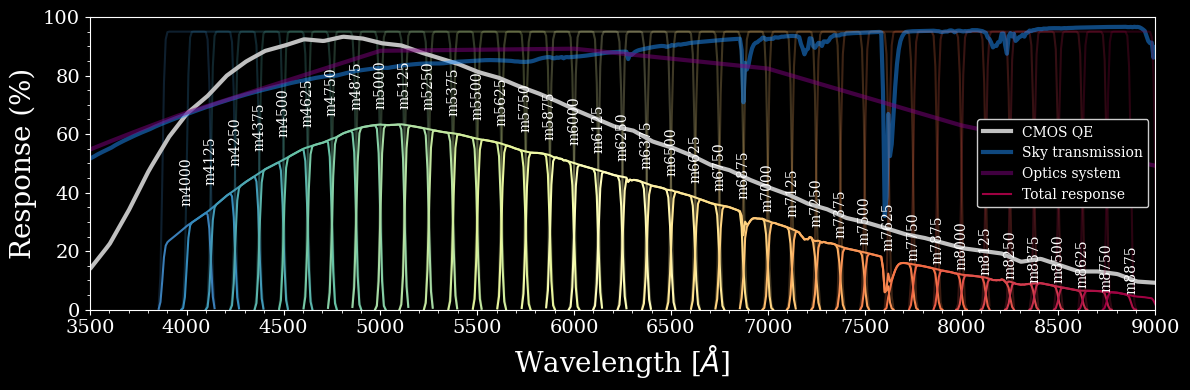

In [107]:
#	Exposure Time [s]
sdt = SevenDT()
sdt.echo_optics()
filterset = sdt.generate_filterset(bandmin=bandmin, bandmax=bandmax, bandwidth=bandwidth, bandstep=bandstep, bandrsp=bandrsp, lammin=lammin, lammax=lammax, lamres=lamres)
T_qe = sdt.get_CMOS_IMX455_QE()
sdt.get_optics()
s = sdt.get_sky()
sdt.smooth_sky()
totrsptbl = sdt.calculate_response()
Npix_ptsrc, Narcsec_ptsrc = sdt.get_phot_aperture(exptime=exptime, fwhm_seeing=seeing, optfactor=1.0, verbose=False)
outbl_ris = sdt.get_depth_table(Nsigma=5)
sdt.get_speclite()

## Initial Setting

In [108]:
path_save = '../output/SPSS'
if not os.path.exists(path_save): os.makedirs(path_save)

In [109]:
path_spss_spectrum = '../data/SPSS'

In [110]:
intbl = Table.read('../data/Spectrophotometric_Standards.csv')
intbl['spectrum'] = False
intbl['spectrum_file'] = ' '*100
c_spss = SkyCoord(intbl['RA'], intbl['Dec'], unit=(u.hourangle, u.deg))
intbl[:3]
print(f"{len(intbl)} found")

68 found


In [111]:
for ss, star in enumerate(intbl['StarName']):
	_spectra = sorted(glob.glob(f"{path_spss_spectrum}/*f{star.upper()}.dat")) + sorted(glob.glob(f"{path_spss_spectrum}/*f{star.lower()}.dat")) + sorted(glob.glob(f"{path_spss_spectrum}/*f{star.lower().replace('-', '_')}.dat")) + sorted(glob.glob(f"{path_spss_spectrum}/*f{star.lower().replace('-', '')}.dat")) + sorted(glob.glob(f"{path_spss_spectrum}/*f{star.lower().replace('+', '')}.dat"))
	_n_spectra = len(_spectra)
	if _n_spectra == 0:
		print(f"{star}: {_spectra}")
	else:
		intbl['spectrum'][ss] = True
		intbl['spectrum_file'][ss] = _spectra[0]

HZ43: []


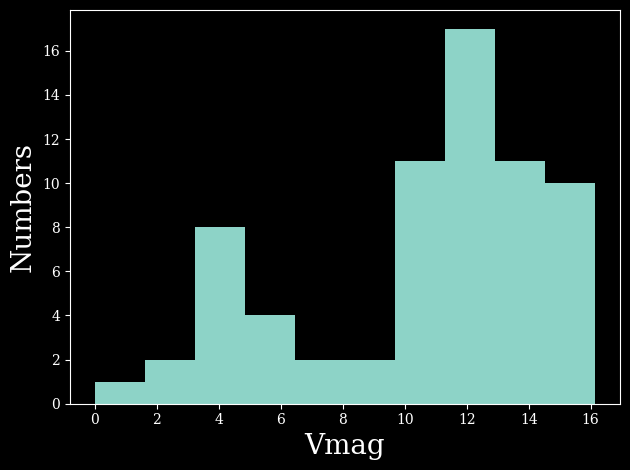

In [112]:
plt.hist(intbl['Vmag'], bins=10)
plt.xlabel("Vmag")
plt.ylabel("Numbers")
plt.tight_layout()

## 7DT Sythetic Photometries

- Single Case

Text(0.5, 1.0, 'HR9087 (V=5.1mag)')

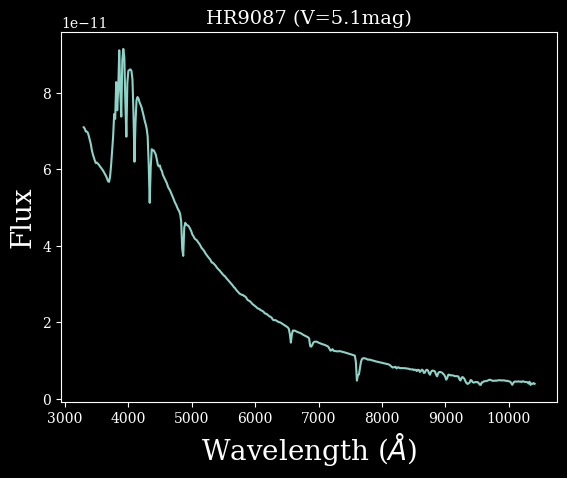

In [113]:
for ss, specfile in enumerate(intbl['spectrum_file']):
	_sptbl = Table.read(specfile, format='ascii')
	starname = intbl['StarName'][ss].item()
	Vmag = intbl['Vmag'][ss].item()
	break

lam = _sptbl['col1']
flam = _sptbl['col2']/10**16

plt.plot(lam, flam)
plt.xlabel(r"Wavelength ($\AA$)")
plt.ylabel("Flux")
plt.title(f"{starname} (V={Vmag:.1f}mag)")

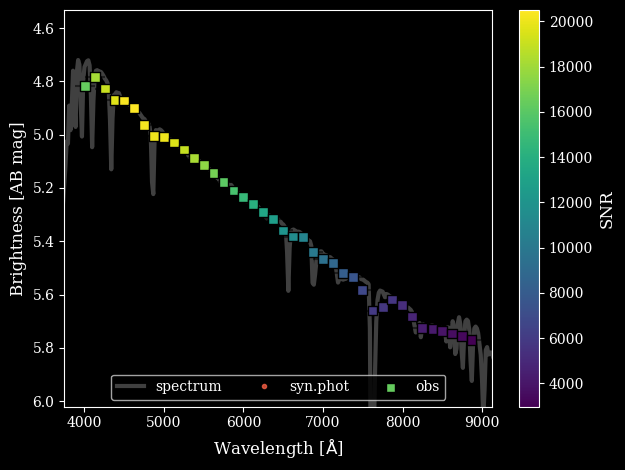

In [114]:
mobstbl = sdt.get_synphot2obs(flam*flamunit, lam*lamunit, z=None, z0=None, figure=True)
# mobstbl['filter'] = [filte[:-1] for filte in mobstbl['filter']]

- Bulk

In [115]:
filterlist = [filte[:-1] for filte in mobstbl['filter']]
lamlist = [float(filte[1:])/10 for filte in mobstbl['filter']]
# lamlist

In [116]:

for nn, filte in enumerate(filterlist):
	intbl[f"{filte}_mag_7dt"] = 0.0

In [117]:
for ss, specfile in enumerate(intbl['spectrum_file']):
	if os.path.exists(specfile):
		_sptbl = Table.read(specfile, format='ascii')
		starname = intbl['StarName'][ss].item()
		Vmag = intbl['Vmag'][ss].item()
		#
		_plotname = f"{path_save}/{starname}_synphot_7DT.png"
		lam = _sptbl['col1']
		flam = _sptbl['col2']/10**16

		if not os.path.exists(_plotname):
			figure = True
		else:
			figure = False
		plt.close('all')
		_mobstbl = sdt.get_synphot2obs(flam*flamunit, lam*lamunit, z=None, z0=None, figure=figure)
		if figure == True: plt.savefig(_plotname)

		for nn, filte in enumerate(_mobstbl['filter']):
			_mag = _mobstbl['magapp'][nn].item()
			intbl[f"{filte[:-1]}_mag_7dt"][ss] = _mag

## Gaia Search Format

Search by position is also allowed, here you can find some examples:

- 19 53 04.689 +36 03 16.38 (hours, degrees)
- 12:11:44.3-44:16:49 (hours, degrees)
- 14h16m-10d11m (hours, degrees)
- 265d10m14.6954s+16d58m58.876s (degrees, degrees)
- 12.34567h-16.87654d (hours, degrees)
- 280.123456d-16.43d (degrees, degrees)
- 320.6543-18.22 (degrees, degrees)

In [118]:
if not os.path.exists(f"{path_save}/Gaia_Query.txt"):
	f = open(f"{path_save}/Gaia_Query.txt", "w")
	for ra, dec in intbl['RA', 'Dec']:
		# print(f"{ra} {dec}")
		f.write(f"{ra} {dec}\n")
	f.close()

## Check Synthetic Photometries

In [119]:
syntbl = Table.read('../data/Gaia/gaiaxp_dr3_synphot_SPSS.csv')
c_gaia = SkyCoord(syntbl['ra'], syntbl['dec'], unit='deg')

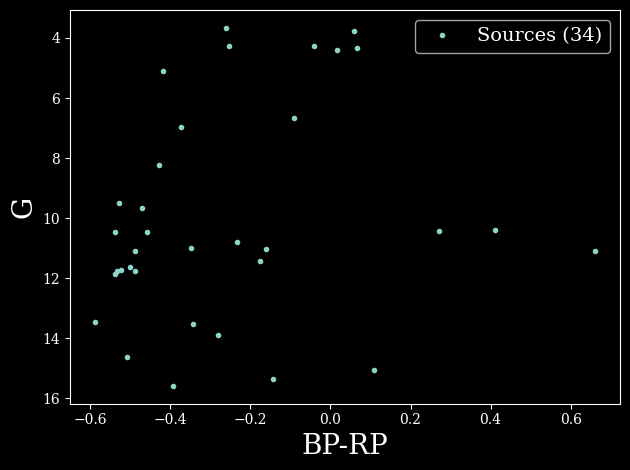

In [120]:
plt.plot(syntbl['bp_rp'], syntbl['phot_g_mean_mag'], '.', label=f'Sources ({len(syntbl)})')
plt.xlabel("BP-RP")
plt.ylabel("G")
plt.gca().invert_yaxis()
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.savefig(f"{path_save}/color_magnitude_diagram_Gaia.png")

In [121]:
indx, sep, _ = c_gaia.match_to_catalog_sky(c_spss)

In [122]:
comtbl = hstack([syntbl, intbl[indx]])
comtbl['sep'] = sep.arcsec

In [123]:
sep_cut = 5
# comtbl[comtbl['sep']<sep_cut]

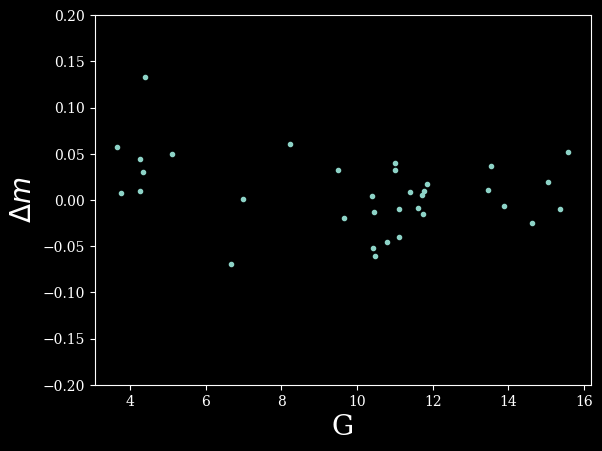

In [124]:
for ff, filte in enumerate(filterlist):
	delmag = comtbl[f'{filte}_mag_7dt'] - comtbl[f'{filte}_mag']
	bprp = comtbl['bp_rp']
	g = comtbl['phot_g_mean_mag']
	# plt.plot(bprp, delmag, '.')
	# plt.xlabel("BP-RP")
	#
	plt.plot(g, delmag, '.')
	plt.xlabel("G")
	plt.ylabel(r"$\Delta m$")
	plt.ylim([-0.2, +0.2])
	break

In [125]:
# med_delmags = []
# std_delmags = []

# for ff, filte in enumerate(filterlist):
# 	delmag = comtbl[f'{filte}_mag_7dt'] - comtbl[f'{filte}_mag']
# 	med_delmag = np.median(delmag)
# 	med_delmags.append(med_delmag)
# 	std_delmag = np.std(delmag)
# 	std_delmags.append(std_delmag)

# 	bprp = comtbl['bp_rp']
# 	g = comtbl['phot_g_mean_mag']

# 	_plotname = f"{path_save}/color_dependence_{filte}.png"

# 	if not os.path.exists(_plotname):
# 		plt.close()
# 		plt.scatter(bprp, delmag, c=g, ec='k', vmin=4, vmax=16, zorder=2)
# 		plt.axhline(y=med_delmag, ls='--', lw=3, color='tomato', zorder=1, label=f"{med_delmag:.3f}"+r"$\pm$"+f"{std_delmag:.3f}")
# 		plt.axhspan(ymin=med_delmag-std_delmag, ymax=med_delmag+std_delmag, color='tomato', alpha=0.25, zorder=0)
# 		cbar = plt.colorbar()
# 		cbar.set_label('G')

# 		plt.xlabel("BP-RP")
# 		#
# 		# plt.plot(g, delmag, '.')
# 		# plt.xlabel("G")
# 		plt.title(filte)
# 		plt.ylabel(r"$\Delta m$")
# 		plt.ylim([-0.2, +0.2])
# 		plt.legend(loc='upper right', fontsize=12)
# 		plt.tight_layout()
# 		plt.savefig(_plotname)
# 		# break

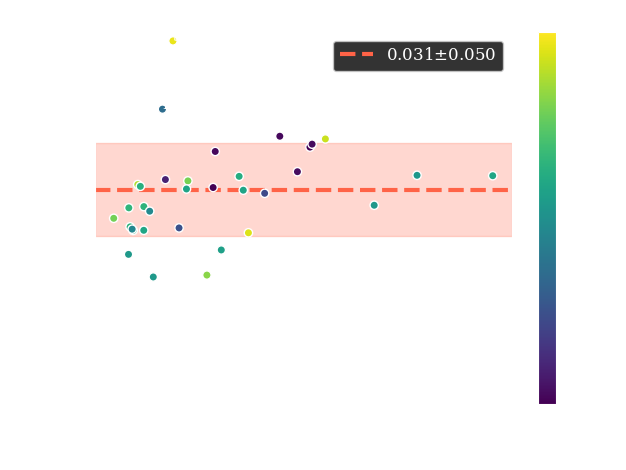

In [133]:


med_delmags = []
std_delmags = []

for ff, filte in enumerate(filterlist):
	delmag = comtbl[f'{filte}_mag_7dt'] - comtbl[f'{filte}_mag']
	med_delmag = np.median(delmag)
	med_delmags.append(med_delmag)
	std_delmag = np.std(delmag)
	std_delmags.append(std_delmag)

	bprp = comtbl['bp_rp']
	g = comtbl['phot_g_mean_mag']

	_plotname = f"{path_save}/color_dependence_{filte}_name.png"

	if not os.path.exists(_plotname):
		plt.close()

		fig = plt.figure(facecolor='none', edgecolor='none', alpha=0)
		ax = fig.add_subplot(1, 1, 1)
		# 축 배경 투명하게 설정
		ax.set_facecolor('none')

		# plt.scatter(bprp, delmag, c=g, ec='k', vmin=4, vmax=16, zorder=2)
		plt.scatter(bprp, delmag, c=g, ec='w', vmin=4, vmax=16, zorder=2)
		plt.axhline(y=med_delmag, ls='--', lw=3, color='tomato', zorder=1, label=f"{med_delmag:.3f}"+r"$\pm$"+f"{std_delmag:.3f}")
		plt.axhspan(ymin=med_delmag-std_delmag, ymax=med_delmag+std_delmag, color='tomato', alpha=0.25, zorder=0)
		cbar = plt.colorbar()
		cbar.set_label('G')

		for oo, delm in enumerate(delmag):
			if np.abs(delm) > 0.1:
				starname = comtbl['StarName'][oo]
				plt.text(bprp[oo], delmag[oo], starname)


		plt.xlabel("BP-RP")
		#
		# plt.plot(g, delmag, '.')
		# plt.xlabel("G")
		plt.title(filte)
		plt.ylabel(r"$\Delta m$")
		plt.ylim([-0.2, +0.2])
		plt.legend(loc='upper right', fontsize=12)
		plt.tight_layout()
		plt.savefig(_plotname, transparent=True)

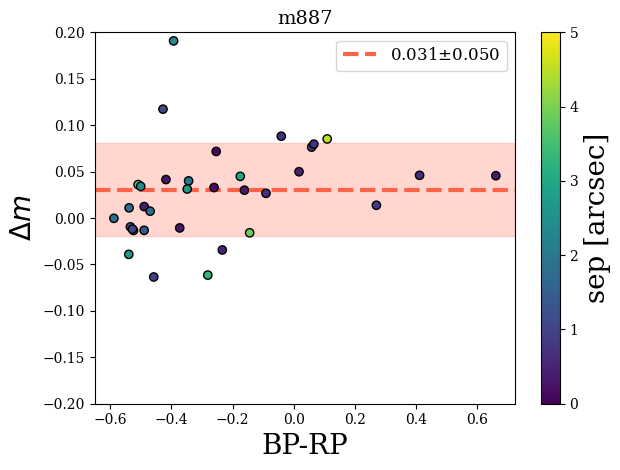

In [97]:
# med_delmags = []
# std_delmags = []

# for ff, filte in enumerate(filterlist):
# 	delmag = comtbl[f'{filte}_mag_7dt'] - comtbl[f'{filte}_mag']
# 	med_delmag = np.median(delmag)
# 	med_delmags.append(med_delmag)
# 	std_delmag = np.std(delmag)
# 	std_delmags.append(std_delmag)

# 	bprp = comtbl['bp_rp']
# 	g = comtbl['phot_g_mean_mag']
# 	sep = comtbl['sep']

# 	__plotname = f"{path_save}/color_dependence_{filte}_sep.png"

# 	if not os.path.exists(__plotname):
# 		plt.close()
# 		# plt.scatter(bprp, delmag, c=sep, ec='k', vmin=4, vmax=16, zorder=2)
# 		plt.scatter(bprp, delmag, c=sep, ec='k', vmin=0, vmax=5, zorder=2)
# 		plt.axhline(y=med_delmag, ls='--', lw=3, color='tomato', zorder=1, label=f"{med_delmag:.3f}"+r"$\pm$"+f"{std_delmag:.3f}")
# 		plt.axhspan(ymin=med_delmag-std_delmag, ymax=med_delmag+std_delmag, color='tomato', alpha=0.25, zorder=0)
# 		cbar = plt.colorbar()
# 		cbar.set_label('sep [arcsec]')

# 		plt.xlabel("BP-RP")
# 		#
# 		# plt.plot(g, delmag, '.')
# 		# plt.xlabel("G")
# 		plt.title(filte)
# 		plt.ylabel(r"$\Delta m$")
# 		plt.ylim([-0.2, +0.2])
# 		plt.legend(loc='upper right', fontsize=12)
# 		plt.tight_layout()
# 		plt.savefig(__plotname)
# 		# break

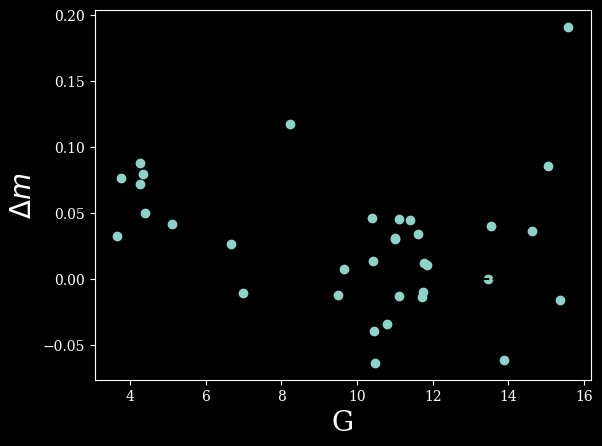

In [128]:
plt.plot(g, delmag, 'o')
plt.xlabel('G')
plt.ylabel(r"$\Delta m$")
plt.axhline(y=0, ls='--', c='k')

In [129]:
comtbl['StarName', 'parallax', 'sep', 'Vmag'][delmag > 0.10]

StarName,parallax,sep,Vmag
str11,float64,float64,float64
SA95-42,5.809119540496011,2.35375034634108,15.61
HD49798,1.919602421918558,1.1200428172293004,8.3


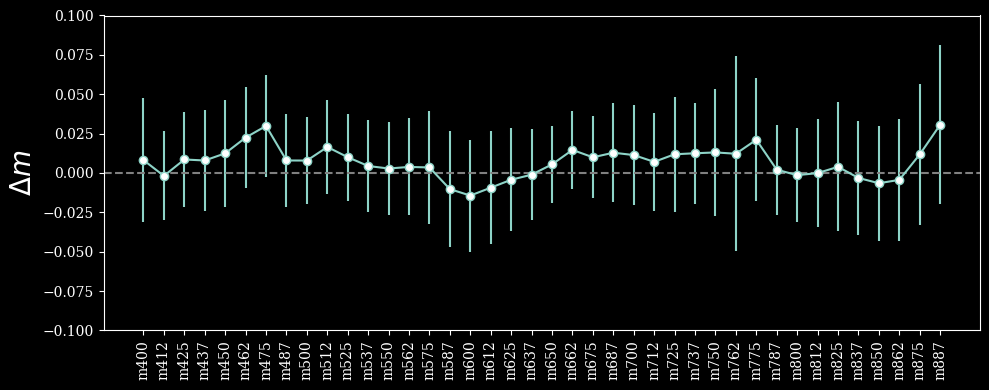

In [130]:
fig = plt.figure(figsize=(10, 4))
plt.errorbar(lamlist, med_delmags, yerr=std_delmags, marker='o', mfc='w')
plt.axhline(y=0, ls='--', color='grey')
_ = plt.xticks(lamlist, filterlist, rotation=90)
plt.ylim(-0.1, 0.1)
plt.ylabel(r"$\Delta m$")
plt.tight_layout()
plt.savefig(f"{path_save}/overall_difference.png")

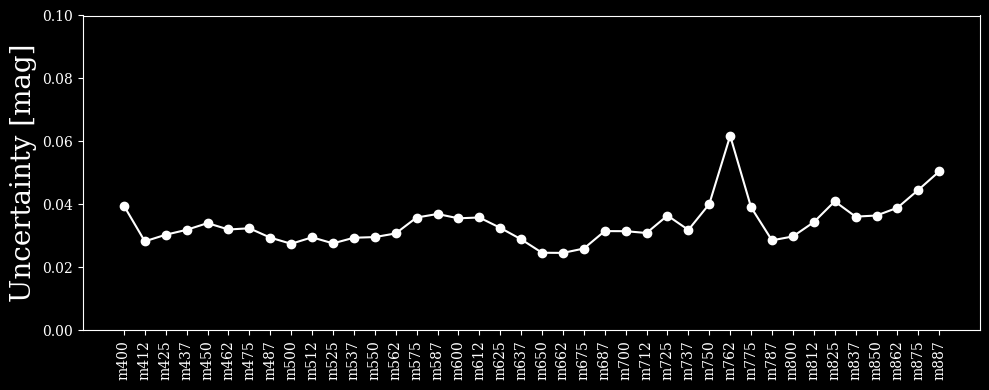

In [132]:
fig = plt.figure(figsize=(10, 4))
plt.plot(lamlist, std_delmags, 'o-', c='w', mfc='w')
# plt.axhline(y=0, ls='--', color='grey')
_ = plt.xticks(lamlist, filterlist, rotation=90)
# plt.ylim(-0.1, 0.1)
plt.ylim(0, 0.1)
plt.ylabel("Uncertainty [mag]")
plt.tight_layout()
plt.savefig(f"{path_save}/overall_difference_uncertainty.png")